In [0]:
#я не торч просто дунул
import torch
import sklearn.datasets

In [0]:
#воспроизводимость
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [0]:
wine_dataset = sklearn.datasets.load_wine()


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(wine_dataset.data,
                                                    wine_dataset.target,
                                                    test_size=.3,
                                                    shuffle=True)
print(X_train.shape, y_train.shape)
print(np.unique(y_train))

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

((124, 13), (124,))
[0 1 2]


In [0]:
import time
class ClassificationNet(torch.nn.Module):
  def __init__(self, n_hidden_neurons, n_epochs=3000, lr=.001, batch_size=100,
               save_time_history=False):
    super(ClassificationNet, self).__init__()
    self.fc1 = torch.nn.Linear(13, n_hidden_neurons)
    self.act1 = torch.nn.Sigmoid()
    self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
    self.act2 = torch.nn.Sigmoid()
    self.fc3 = torch.nn.Linear(n_hidden_neurons, 3)
    self.sm = torch.nn.Softmax(dim=1)
    
    self.n_epochs = n_epochs
    self.lr = lr
    self.batch_size = batch_size
    self.save_time_history = save_time_history
 
  def forward(self, x):
    x = self.fc1(x)
    x = self.act1(x)
    x = self.fc2(x)
    x = self.act2(x)
    x = self.fc3(x)
    return x
  
  def train(self, x, y):
    loss = torch.nn.CrossEntropyLoss() #ждет НЕ Softmax выход (убран логарифм)
    optimizer = torch.optim.Adam(self.parameters(), self.lr)
    
    #batch gd
    for _ in range(self.n_epochs):
      self.time_history_ = []
      start_time = time.time()

      shuffled_indexes = np.random.permutation(x.shape[0])
      
      for start_index in range(0, len(shuffled_indexes), self.batch_size):
        x_batch = x[shuffled_indexes[start_index:start_index+self.batch_size]]
        y_batch = y[shuffled_indexes[start_index:start_index+self.batch_size]]
        
        optimizer.zero_grad()
        y_output = self.forward(x_batch)
        loss_val = loss(y_output, y_batch)
        loss_val.backward()
        optimizer.step()
        
        if self.save_time_history:
          self.time_history_.append(time.time() - start_time)
        
    return self
  
  def predict(self, x):
    return self.forward(x).argmax(dim=1)
  
  def predict_proba(self, x):
    return self.sm(self.forward(x))

In [42]:
#Какой Base Line у датасета вин?
from scipy import stats
def base_predict(y):
  return [stats.mode(y.data)[0][0]]*len(y)

from sklearn.metrics import accuracy_score
base_line = accuracy_score(base_predict(y_test), y_test)
print(base_line)

0.39751552795031053


In [33]:
#Попробуйте передавать различные значения test_size в функцию train_test_split.
#При каком значении test_size сеть предсказывает хуже чем Base Rate?


0.4074074074074074

In [0]:
accuracy_list = []
for testsize in [.1, .2, .3, .4, 5, .6, .7, .8, .9]:
  accuracy = 0
  for _ in range(10):
    
    X_train, X_test, y_train, y_test = train_test_split(wine_dataset.data,
                                                    wine_dataset.target,
                                                    test_size=testsize,
                                                    shuffle=True)
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.LongTensor(y_train)
    y_test = torch.LongTensor(y_test)

    model = ClassificationNet(20, batch_size=10, n_epochs=100)
    model.train(X_train, y_train)
    accuracy += accuracy_score(model.predict(X_test), y_test)
    #print(accuracy)
    
  accuracy_list.append(accuracy / 10)

In [92]:
accuracy_list

[0.6222222222222222,
 0.7055555555555557,
 0.6777777777777778,
 0.6,
 0.6799999999999999,
 0.608411214953271,
 0.6239999999999999,
 0.5804195804195804,
 0.3720496894409938]

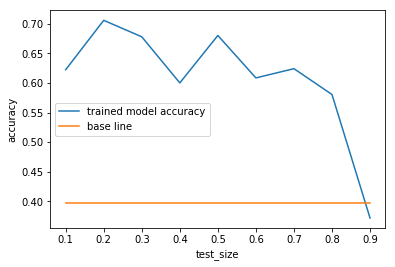

In [93]:
import matplotlib.pyplot as plt
plt.plot([.1, .2, .3, .4, .5, 0.6, .7, .8, .9], accuracy_list, label='trained model accuracy')
plt.plot([.1, .2, .3, .4, .5, .6, .7, .8, .9], [base_line]*9, label='base line')
plt.xlabel('test_size')
plt.ylabel('accuracy')
plt.legend();

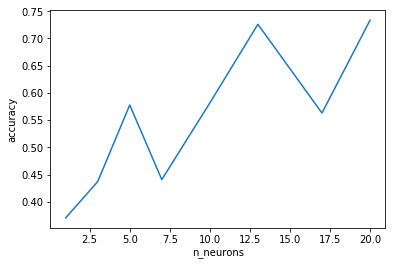

In [101]:
#Поэкспериментируйте с количеством нейронов в скрытых слоях. Попробуйте поставить очень маленькое число.
#Существует ли пороговое значение количества скрытых нейронов, при котором обучение становится невозможным?
X_train, X_test, y_train, y_test = train_test_split(wine_dataset.data,
                                                    wine_dataset.target,
                                                    test_size=.3,
                                                    shuffle=True)
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

accuracy_list = []
for n_neurons in [1, 3, 5, 7, 10, 13, 15, 17, 20]:
  accuracy = 0
  for _ in range(5):
    model = ClassificationNet(n_neurons, batch_size=10, n_epochs=100)
    model.train(X_train, y_train)
    accuracy += accuracy_score(model.predict(X_test), y_test)
    #print(accuracy)
    
  accuracy_list.append(accuracy / 5)
  
plt.plot([1, 3, 5, 7, 10, 13, 15, 17, 20], accuracy_list)
plt.xlabel('n_neurons')
plt.ylabel('accuracy');

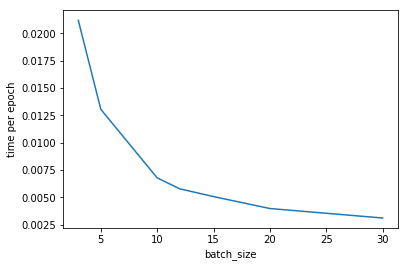

In [102]:
#Зависит ли время обучения на одной эпохе от размера батча? Исследуйте эту зависимость.
import numpy
time_history = []
for batchsize in [3, 5, 10, 12, 15, 20, 30]:
    model = ClassificationNet(20, batch_size=batchsize, n_epochs=20, save_time_history=True)
    model.train(X_train, y_train)
    time_history.append(numpy.mean(model.time_history_))
    
plt.plot([3, 5, 10, 12, 15, 20, 30], time_history)
plt.xlabel('batch_size')
plt.ylabel('time per epoch');